In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import torch.optim as optim
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

In [2]:
# For M
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# For M' and M'' and M*
class Net_sub(nn.Module):
    def __init__(self):
        super(Net_sub, self).__init__()
        self.fc1 = nn.Linear(784, 64) # subbed from gaussian
        self.fc2 = nn.Linear(64, 64)  # changed to match dimension
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
  
# CIFAR 100 

In [3]:
M = Net()
M.load_state_dict(torch.load('model.pth'))
M.eval()

Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

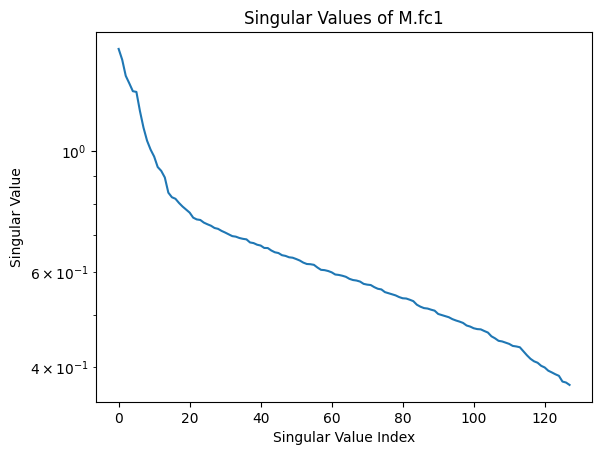

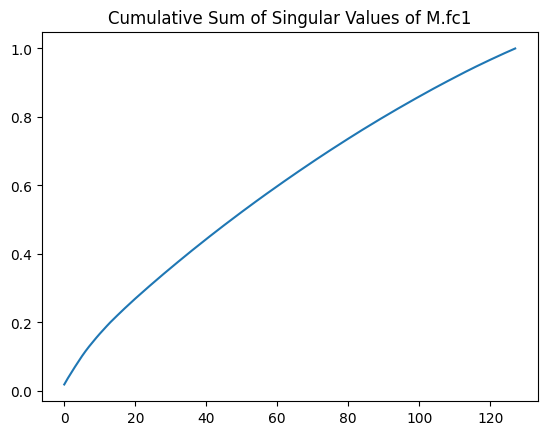

In [4]:
T = M.fc1.weight.data.clone().detach()
U,S,VT = np.linalg.svd(T.numpy(), full_matrices=False)
S = np.diag(S)
plt.figure(1)
plt.semilogy((np.diag(S)))
plt.title('Singular Values of M.fc1')
plt.xlabel('Singular Value Index')
plt.ylabel('Singular Value')
plt.show()

plt.figure(2)
plt.plot(np.cumsum(np.diag(S))/np.sum(np.diag(S)))
plt.title('Cumulative Sum of Singular Values of M.fc1')
plt.show()

In [5]:
# T is original weight matrix, U is left singular vectors, S is singular values, VT is right singular vectors
print(f'T shape: {T.shape}\nU shape: {U.shape}\nS shape: {S.shape}\nVT shape: {VT.shape}')
# Approximation of T using only half of the singular values
XApprox = U[:,U.shape[1]//2:] @ S[0:S.shape[0]//2, : S.shape[1]//2] @ VT[: VT.shape[0]//2,:]
print( f'XApprox.shape {XApprox.shape}, Error: {np.linalg.norm(T.numpy() - XApprox)}') 

T shape: torch.Size([128, 784])
U shape: (128, 128)
S shape: (128, 128)
VT shape: (128, 784)
XApprox.shape (128, 784), Error: 10.10550308227539


In [6]:
M_new = Net()
M_new.fc1.weight.data = torch.tensor(XApprox)
M_new.fc1.bias.data = M.fc1.bias.data.clone().detach()
M_new.fc2.weight.data = M.fc2.weight.data.clone().detach()
M_new.fc2.bias.data = M.fc2.bias.data.clone().detach()
M_new.fc3.weight.data = M.fc3.weight.data.clone().detach()
M_new.fc3.bias.data = M.fc3.bias.data.clone().detach()
M_new.eval()

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        output = M_new(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

accuracy = 100 * correct / total

print(f'Test Accuracy model: {accuracy}%')


Test Accuracy model: 15.63%


### $\text{Test accuracy model with gaussian convolution and Adaptive max pooling: } 17.83\%$
### $\text{Test accuracy model with low rank approximation: } 15.63\%$

In [7]:
def create_S(W, output_size, num_iterations=1, dtype=torch.float32):
    # Convert to tensor
    S = torch.tensor(W, dtype=dtype)
    print(S.shape)
    # Add dimensions to S to make it a 4D tensor if it's not already
    while len(S.shape) < 4:
        S = S.unsqueeze(0)

    # Ensure output_size is a list so we can modify it if necessary
    output_size = list(output_size)

    # If S is a 1D tensor, adjust output_size to match
    if len(W.shape) == 1 and len(output_size)==1:
        output_size = [output_size[0], 1]
    # Calculate the step size for each dimension
    step_size = [(S.shape[i] - output_size[i]) // num_iterations for i in range(len(output_size))]
    if len(W.shape) == 1:
        s_shape = W.shape[0]
    else:
        s_shape = S.shape[-2]
    print(s_shape)
    for i in range(num_iterations):
        # Apply Gaussian filter
        #sigma = 1.0*num_iterations/(i+1)
        #S_np = S.numpy()  # Convert to NumPy array
        #S_filtered = gaussian_filter(S_np, sigma=sigma)
        #S = torch.from_numpy(S_filtered)  # Convert back to tensor
        # Calculate the target size for this iteration
        if i < num_iterations - 1:
            target_zero = s_shape + step_size[0]
            target_size = [target_zero, output_size[1] ]
            s_shape = target_zero
        else:
            target_size = output_size
        print(target_size)
        # Create adaptive max pooling layer
        pool = nn.AdaptiveMaxPool2d(target_size)

        # Apply adaptive max pooling
        S = pool(S)
    # Remove the added dimensions
    S = S.squeeze()

    return S
    # sigma = 1.0
    # S = gaussian_filter(S, sigma=sigma)
    # S = torch.tensor(S, dtype=dtype)
    # S = S.unsqueeze(0).unsqueeze(0)
    # pool = nn.AdaptiveMaxPool2d(output_size)
    # S = pool(S)
    # S = S.squeeze()

A_dash_weights_L1 = create_S(W = M_new.fc1.weight.data.clone().detach(), output_size= (64, 784))
A_dash_bias_L1 = create_S(M_new.fc1.bias.data.clone().detach(), (64, 1))
A_dash_weights_L2 = (create_S((M_new.fc2.weight.data.clone().detach()).T, (64, 64))).T

print(A_dash_weights_L1.shape, A_dash_bias_L1.shape, A_dash_weights_L2.shape)

torch.Size([128, 784])
128
[64, 784]
torch.Size([128])
128
[64, 1]
torch.Size([128, 64])
128
[64, 64]
torch.Size([64, 784]) torch.Size([64]) torch.Size([64, 64])


/var/folders/md/3dw2nsvn0vd_fzy_p6gjshqh0000gn/T/ipykernel_5766/1293753232.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  S = torch.tensor(W, dtype=dtype)


In [8]:
M_dash = Net_sub()

M_dash.fc1.weight.data = A_dash_weights_L1
M_dash.fc1.bias.data = A_dash_bias_L1

M_dash.fc2.weight.data = A_dash_weights_L2
M_dash.fc2.bias.data = M_new.fc2.bias.data.clone()

M_dash.fc3.weight.data = M_new.fc3.weight.data.clone()
M_dash.fc3.bias.data = M_new.fc3.bias.data.clone()


In [9]:
# Load the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [10]:
M_dash.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        output = M_dash(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

accuracy = 100 * correct / total

print(f'Test Accuracy model: {accuracy}%')

Test Accuracy model: 9.07%
